The link to kaggle notebook: <br><br>
https://www.kaggle.com/code/anirbanmalick/image-colorization-pytorch-conv-autoencoder/notebook

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
     for filename in filenames:
#         print(os.path.join(dirname, filename))
        i =0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage.color import rgb2lab, lab2rgb
from torchinfo import summary
from tqdm import tqdm

In [3]:
import random

random_indices = random.sample(list(range(7000)),7000)
train_nums = round(7000*0.5)
train_indices = random_indices[:train_nums]
test_indices = random_indices[train_nums:]
len(train_indices), len(test_indices)

(3500, 3500)

## Creating Dataset

In [4]:
class EncoderDataset(Dataset):
    def __init__(self, indices, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_indices = indices
        self.gray_path = img_dir+'gray/'
        self.color_path = img_dir+'color/'
    
    def __len__(self):
        return len(self.img_indices)
        
    def __getitem__(self, idx):
        img_name = str(idx)+'.jpg'
        image = read_image(self.gray_path+img_name)
        image = image.unsqueeze(0)
        image = F.interpolate(image,(160,160))
        image = image.squeeze(0)
        image = image.permute(1,2,0)
        image = image.repeat(1,1,3)
        image = image.permute(2,0,1)
        label = read_image(self.color_path+img_name)
        label = label.unsqueeze(0)
        label = F.interpolate(label,(160,160))
        label = label.squeeze(0)
        label = label.permute(1,2,0)
        label = label.permute(2,0,1)
        image = torch.tensor(rgb2lab(image.permute(1,2,0)/255))
        label = torch.tensor(rgb2lab(label.permute(1,2,0)/255))
        
        image = (image + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        label = (label + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        
        image = image.permute(2,0,1)
        label = label.permute(2,0,1)
        #Use L channel from image to predict a,b channels of label
        image = image[:1,:,:]
        label = label[1:,:,:] 
        return image, label

In [5]:
train_dataset = EncoderDataset(indices = train_indices,img_dir = "/kaggle/input/landscape-image-colorization/landscape Images/")
test_dataset = EncoderDataset(indices = test_indices,img_dir = "/kaggle/input/landscape-image-colorization/landscape Images/")
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Visualising

In [6]:
img,label = next(iter(train_dataloader))
sample_image,sample_label = img[5], label[5]
print(sample_image.shape, sample_label.shape)

torch.Size([1, 160, 160]) torch.Size([2, 160, 160])


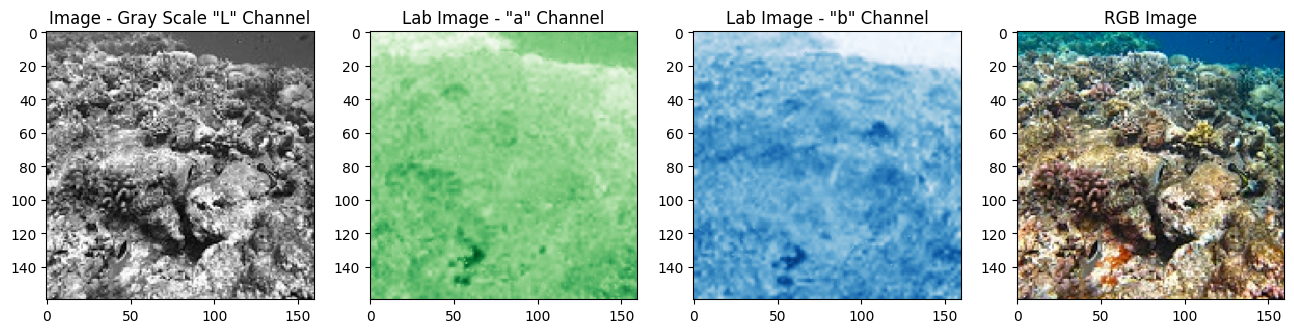

In [7]:
fig = plt.figure(figsize=(16,16))
plt.subplot(441)
plt.imshow(sample_image.permute(1,2,0),cmap='gray')
plt.title('Image - Gray Scale "L" Channel')
plt.subplot(442)
plt.imshow(sample_label.permute(1,2,0)[:,:,0],cmap='Greens')
plt.title('Lab Image - "a" Channel')

plt.subplot(443)
plt.imshow(sample_label.permute(1,2,0)[:,:,1],cmap='Blues')
plt.title('Lab Image - "b" Channel')

plt.subplot(444)
color_image = torch.cat((sample_image,sample_label),dim=0).permute(1,2,0)
color_image = color_image * torch.tensor([100,255,255]) -torch.tensor([0,128,128])
color_image = lab2rgb(color_image)
plt.imshow(color_image)
plt.title('RGB Image')
plt.show()

## Model

In [8]:
class ConvEnc(nn.Module):
    def __init__(self):
        super(ConvEnc, self).__init__()
        self.conv1 = nn.Conv2d(1,64,3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=2,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,stride=2,padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3,stride=2,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(256, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(256, 64, 3, stride=2,padding=1,output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(128, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv4 = nn.ConvTranspose2d(192, 15, 3, stride=1,padding=1)
        self.dropout = nn.Dropout(0.3)
        self.converge = nn.Conv2d(16,2,3,stride=1,padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        x4 = F.relu(self.conv4(x3))
        xd = F.relu(self.t_conv1(x4))
        xd = torch.cat((xd, x3), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv2(xd))
        xd = torch.cat((xd, x2), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv3(xd))
        xd = torch.cat((xd, x1), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv4(xd))
        xd = torch.cat((xd, x), dim=1)
        x_out = F.relu(self.converge(xd))
        return x_out

model = ConvEnc()
print(model)
model = ConvEnc().to('cuda')

ConvEnc(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv3): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv4): ConvTranspose2d(192, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (converge): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [9]:
summary(model, input_size=(32,1,160,160))

Layer (type:depth-idx)                   Output Shape              Param #
ConvEnc                                  [32, 2, 160, 160]         --
├─Conv2d: 1-1                            [32, 64, 160, 160]        640
├─Conv2d: 1-2                            [32, 64, 80, 80]          36,928
├─Conv2d: 1-3                            [32, 128, 40, 40]         73,856
├─Conv2d: 1-4                            [32, 256, 20, 20]         295,168
├─ConvTranspose2d: 1-5                   [32, 128, 40, 40]         295,040
├─Dropout: 1-6                           [32, 256, 40, 40]         --
├─ConvTranspose2d: 1-7                   [32, 64, 80, 80]          147,520
├─Dropout: 1-8                           [32, 128, 80, 80]         --
├─ConvTranspose2d: 1-9                   [32, 128, 160, 160]       147,584
├─Dropout: 1-10                          [32, 192, 160, 160]       --
├─ConvTranspose2d: 1-11                  [32, 15, 160, 160]        25,935
├─Conv2d: 1-12                           [32, 2, 160

In [10]:
# specify loss function
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 50
train_losses = []
test_losses = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data in tqdm(train_dataloader):
        images, labels = data
        images = images.float().to('cuda')
        labels = labels.float().to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    train_loss = train_loss/len(train_dataloader)
    train_losses.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    
    test_loss = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        for images, labels in test_dataloader:
            images, labels = images.to('cuda'), labels.to('cuda')
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.size(0)                
    model.train()
    test_loss = test_loss/len(test_dataloader)
    print("Test Loss: {:.3f}.. ".format(test_loss))
    test_losses.append(test_loss)

  4%|▎         | 8/219 [00:03<01:33,  2.25it/s]

Visualising the prediction

In [ ]:
##Training Data
i=0
while i<20:
    test_img,test_label = next(iter(train_dataloader))
    pred = model.forward(test_img[0].float().to('cuda').view(1,1,160,160))
    lab_pred = torch.cat((test_img[0].view(1,160,160),pred[0].cpu()),dim=0)
    lab_pred_inv_scaled = lab_pred.permute(1,2,0) * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    rgb_pred = lab2rgb(lab_pred_inv_scaled.detach().numpy())
    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(test_img[0].permute(1,2,0),cmap='gray')
    plt.title('GrayScale Image')
    plt.subplot(222)
    plt.imshow(rgb_pred)
    plt.title('Predicted Color Image')
    plt.show()
    i+=1

In [ ]:
##Test Data
i=0
while i<20:
    test_img,test_label = next(iter(test_dataloader))
    pred = model.forward(test_img[0].float().to('cuda').view(1,1,160,160))
    lab_pred = torch.cat((test_img[0].view(1,160,160),pred[0].cpu()),dim=0)
    lab_pred_inv_scaled = lab_pred.permute(1,2,0) * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    rgb_pred = lab2rgb(lab_pred_inv_scaled.detach().numpy())
    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(test_img[0].permute(1,2,0),cmap='gray')
    plt.title('GrayScale Image')
    plt.subplot(222)
    plt.imshow(rgb_pred)
    plt.title('Predicted Color Image')
    plt.show()
    i+=1

In [ ]:
torch.save(model.state_dict(),'Encoder-30epochs')